In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Importing prequiste package for case study

In [3]:
# importing required libraries
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
from keras.layers import Input, Embedding, LSTM, Dropout, BatchNormalization, Dense, concatenate, Flatten, Conv1D, MaxPool1D, LeakyReLU, ELU, SpatialDropout1D, MaxPooling1D, GlobalAveragePooling1D, GlobalMaxPooling1D
from keras.preprocessing.text import Tokenizer, one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Model, load_model
from keras import regularizers
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard, ReduceLROnPlateau
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics import roc_auc_score
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
import re
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import pickle
# from keras.layers import Bidirectional,TimeDistributed,AttLayer, CuDNNGRU, CuDNNLSTM,
from keras.layers import Bidirectional
from keras.layers import TimeDistributed 
from keras.layers import CuDNNGRU 
from keras.layers import CuDNNLSTM
from keras import initializers, regularizers, constraints
from keras.layers import SpatialDropout1D
import warnings
warnings.filterwarnings("ignore")

Using TensorFlow backend.


### Pre-processing steps

In [0]:
# We clean the essay text data
# For this task, we have defined some helper functions
# The same function and code snippet will be used to clean project title
# https://stackoverflow.com/a/47091490/4084039

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

# https://gist.github.com/sebleier/554280

stopwords= ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"]

In [0]:
# Cleaning Text feature
preprocessed_text = []
# tqdm is for printing the status bar
for sentance in tqdm(project_data['text'].values):
    sent = decontracted(sentance)
    sent = sent.replace('\\r', ' ')
    sent = sent.replace('\\"', ' ')
    sent = sent.replace('\\n', ' ')
    sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
    # https://gist.github.com/sebleier/554280
    sent = ' '.join(e for e in sent.split() if e not in stopwords)
    preprocessed_text.append(sent.lower().strip())

100%|██████████| 109248/109248 [01:00<00:00, 1818.57it/s]


In [0]:
project_data["clean_text"] = preprocessed_text

In [0]:
project_data = project_data.drop(['Unnamed: 0', 'id', 'teacher_id',
                                  'project_submitted_datetime','text'],axis=1)

In [0]:
# we have categorical features also, will do cleaning one by one

# https://stackoverflow.com/questions/36383821/pandas-dataframe-apply-function-to-column-strings-based-on-other-column-value
project_data['project_grade_category'] = project_data['project_grade_category'].str.replace(' ','_')
project_data['project_grade_category'] = project_data['project_grade_category'].str.replace('-','_')
project_data['project_grade_category'] = project_data['project_grade_category'].str.lower()


project_data['project_subject_categories'] = project_data['project_subject_categories'].str.replace(' The ','')
project_data['project_subject_categories'] = project_data['project_subject_categories'].str.replace(' ','')
project_data['project_subject_categories'] = project_data['project_subject_categories'].str.replace('&','_')
project_data['project_subject_categories'] = project_data['project_subject_categories'].str.replace(',','_')
project_data['project_subject_categories'] = project_data['project_subject_categories'].str.lower()


project_data['teacher_prefix']=project_data['teacher_prefix'].fillna('Mrs.')
project_data['teacher_prefix'] = project_data['teacher_prefix'].str.replace('.','')
project_data['teacher_prefix'] = project_data['teacher_prefix'].str.lower()


project_data['project_subject_subcategories'] = project_data['project_subject_subcategories'].str.replace(' The ','')
project_data['project_subject_subcategories'] = project_data['project_subject_subcategories'].str.replace(' ','')
project_data['project_subject_subcategories'] = project_data['project_subject_subcategories'].str.replace('&','_')
project_data['project_subject_subcategories'] = project_data['project_subject_subcategories'].str.replace(',','_')
project_data['project_subject_subcategories'] = project_data['project_subject_subcategories'].str.lower()

project_data['school_state'] = project_data['school_state'].str.lower()

In [0]:
# we will extract numerical digits from the project resource summary

project_summary_numerical = []
for sentance in tqdm(project_data['project_resource_summary']):
    sent1 = decontracted(sentance)
    sent1 = ' '.join(e for e in sent1.split() if e.isdigit())
    k=len(sent1)
    project_summary_numerical.append(k)

project_data["project_summary_numerical"] = project_summary_numerical

100%|██████████| 109248/109248 [00:01<00:00, 71911.93it/s]


### Loading data and topic modeling feature files

In [0]:
project_data = pd.read_csv('/content/drive/My Drive/project_data2.csv')

In [0]:
# Topic_modeling_keywords = pd.read_csv('/content/drive/My Drive/Topic_modeling_donor_choose.csv')

In [0]:
# Topic_modeling_keywords.head()

In [0]:
# topic_keywords = Topic_modeling_keywords.drop(['Document_No','Dominant_Topic','Topic_Perc_Contrib','Text','Unnamed: 0'],axis=1)

In [0]:
# project_data = pd.concat([project_data, topic_keywords],axis=1)

In [9]:
project_data.head(2)

,teacher_prefix,school_state,project_submitted_datetime,project_grade_category,project_title,project_essay_1,project_essay_2,project_essay_3,project_essay_4,project_resource_summary,teacher_number_of_previously_posted_projects,project_is_approved,clean_categories,clean_subcategories,price,quantity,digit_in_summary,clean_text,month,weekday,hour,month_Day,project_summary_numerical
0,mrs,in,2016-12-05 13:43:57,grades_prek_2,Educational Support for English Learners at Home,My students are English learners that are work...,"\""The limits of your language are the limits o...",NaN,NaN,My students need opportunities to practice beg...,0,0,literacy_language,eslliteracy,154.6,23,0,my students english learners working english s...,12,0,13,5,0
1,mr,fl,2016-10-25 09:22:10,grades_6_8,Wanted: Projector for Hungry Learners,Our students arrive to our school eager to lea...,The projector we need for our school is very c...,NaN,NaN,My students need a projector to help with view...,7,1,history_civicshealth_sports,civics_governmentteamsports,299.0,1,0,our students arrive school eager learn they po...,10,1,9,25,0


In [0]:
target = project_data["project_is_approved"]
features = project_data.drop(["project_resource_summary","project_is_approved"],axis=1)

### Splitting data into train and test

In [0]:
# We split our dataset into train,cross-validation and test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(features, target, stratify=target,test_size=0.20,random_state=123)

#### Vectorizing our text feature

In [0]:
# Filtering Text Data based on idf values

vect = TfidfVectorizer()
combine_tfid = vect.fit_transform(X_train["clean_text"])

# converting to dictionary
combine_dict = dict(zip(vect.get_feature_names(),list(vect.idf_)))

In [0]:
tfidf_df = pd.DataFrame(list(combine_dict.items()), columns=['Words', 'IDF Values'])

In [0]:
tfidf_df = tfidf_df.sort_values(by ='IDF Values' )

**Plotting graph to observe the distribution of idf values**

Text(0.5, 1.0, 'Violin plot of idf')

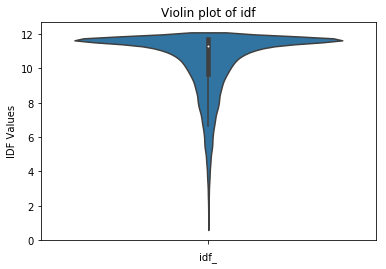

In [15]:
sns.violinplot(x = "IDF Values",data=tfidf_df,orient="v")
plt.xlabel("idf_")
plt.title("Violin plot of idf")

**Here as we can observe more of our idf values falls in range of 10 -12**

**Lets check the percentile value falling in quantiles**

In [16]:
print(np.percentile(tfidf_df['IDF Values'],np.arange(0, 100, 25)))

[ 1.00767247  9.67018892 11.27962683 11.68509194]


from this it is clear that we can take value above 25% percentile 

In [0]:
final_tfidf = tfidf_df[tfidf_df["IDF Values"] <=  np.percentile(tfidf_df['IDF Values'],25)] # considering only tdf value which are more than 25%

In [0]:
corpus = final_tfidf["Words"].tolist()

In [0]:
# convert the sentences (strings) into integers
tokenizer = Tokenizer()
tokenizer.fit_on_texts(corpus)
sequences_train = tokenizer.texts_to_sequences(X_train["clean_text"])
sequences_test = tokenizer.texts_to_sequences(X_test["clean_text"])

In [20]:
# get word -> integer mapping
word2idx = tokenizer.word_index
print('Found %s unique tokens.' % len(word2idx))

Found 13271 unique tokens.


In [22]:
encoded_train = pad_sequences(sequences_train,maxlen=300,padding='post', truncating='post')
print('Shape of data tensor:', encoded_train.shape)

Shape of data tensor: (87398, 300)


In [23]:
encoded_test = pad_sequences(sequences_test, maxlen=300,padding='post', truncating='post')
print('Shape of data tensor:', encoded_test.shape)

Shape of data tensor: (21850, 300)


In [0]:
# Loading Embedding File

pickle_in = open("drive/My Drive/Lstm_donor_choose/glove_vectors","rb")
glove_words = pickle.load(pickle_in)

#### Embedding matrix

In [0]:
num_words = len(word2idx) + 1
embedding_matrix = np.zeros((num_words, 300))
for word, i in word2idx.items():
  if i < 13271:
    embedding_vector = glove_words.get(word)
    if embedding_vector is not None:
      # words not found in embedding index will be all zeros.
      embedding_matrix[i] = embedding_vector

**Using Bi-directional CUDNNGRU and CUDNNLSTM for esssay feature**

In [0]:
embedding_layer = Embedding(num_words,300,weights=[embedding_matrix],input_length=300,trainable=False)
input_text = Input(shape=(300,),name='input_text')
x = embedding_layer(input_text)
x = SpatialDropout1D(0.5)(x)
x = Bidirectional(CuDNNGRU(64, return_sequences=True,kernel_regularizer=regularizers.l2(5e-5),recurrent_regularizer=regularizers.l2(5e-5)))(x)
# x = TimeDistributed(Dense(128))(x)
x = Dropout(0.5)(x)
x = Bidirectional(CuDNNGRU(128, return_sequences=True))(x)
# x = Attention(x)
flatten_1 = Flatten()(x)

In [28]:
X_train.head(2)

,teacher_prefix,school_state,project_submitted_datetime,project_grade_category,project_title,project_essay_1,project_essay_2,project_essay_3,project_essay_4,teacher_number_of_previously_posted_projects,clean_categories,clean_subcategories,price,quantity,digit_in_summary,clean_text,month,weekday,hour,month_Day,project_summary_numerical
7670,mrs,mt,2016-08-28 13:46:00,grades_prek_2,Increasing Engagement for Eager to Learn Kinders,"My students are imaginative, playful, and eage...",These materials truly will make a difference i...,NaN,NaN,0,appliedlearningliteracy_language,earlydevelopmentliteracy,122.95,6,0,my students imaginative playful eager learn 5 ...,8,6,13,28,0
72572,mrs,co,2016-06-11 17:56:44,grades_6_8,Student Connections and Family Communication,My students come from a small town community t...,I am always looking for new ideas to improve m...,NaN,NaN,0,appliedlearning,otherparentinvolvement,114.77,12,0,my students come small town community growing ...,6,5,17,11,0


#### Teacher Prefix feature

In [29]:
# Now will prepare all the remaining categorical features
# Teacher Prefix
no_of_unique_prefix  = X_train["teacher_prefix"].nunique()
embedding_size_prefix = int(min(np.ceil((no_of_unique_prefix)/2), 50 ))
print('Unique Categories:', no_of_unique_prefix,'Embedding Size:', embedding_size_prefix)


# Defining Input and Embedding Layer for the same

input_prefix = Input(shape=(1,),name="teacher_prefix")
embedding_prefix = Embedding(no_of_unique_prefix,embedding_size_prefix,name="emb_pre",trainable=True)(input_prefix)
flatten_2 = Flatten()(embedding_prefix)

lb = LabelEncoder()
encoder_prefix_train = lb.fit_transform(X_train["teacher_prefix"])
# encoder_prefix_cv = lb.transform(X_cv["teacher_prefix"])
encoder_prefix_test = lb.transform(X_test["teacher_prefix"])

Unique Categories: 5 Embedding Size: 3


### School state feature

In [30]:
# School State
no_of_unique_state  = X_train["school_state"].nunique()
embedding_size_state= int(min(np.ceil((no_of_unique_state)/2), 50 ))
print('Unique Categories:', no_of_unique_state,'Embedding Size:', embedding_size_state)

input_state = Input(shape=(1,),name="school_prefix")
embedding_state = Embedding(no_of_unique_state,embedding_size_state,name="emb_state",trainable=True)(input_state)
flatten_3 = Flatten()(embedding_state)


encoder_state_train = lb.fit_transform(X_train["school_state"])
encoder_state_test = lb.transform(X_test["school_state"])

Unique Categories: 51 Embedding Size: 26


### Project Grade category

In [31]:
# For project_grade_category
no_of_unique_grade  = X_train["project_grade_category"].nunique()
embedding_size_grade = int(min(np.ceil((no_of_unique_grade)/2), 50 ))
print('Unique Categories:', no_of_unique_grade,'Embedding Size:', embedding_size_grade)

input_grade= Input(shape=(1,),name="grade_cat")
embedding_grade = Embedding(no_of_unique_grade,embedding_size_grade,name="emb_grade",trainable=True)(input_grade)
flatten_4 = Flatten()(embedding_grade)


encoder_grade_train = lb.fit_transform(X_train["project_grade_category"])
encoder_grade_test = lb.transform(X_test["project_grade_category"])

Unique Categories: 4 Embedding Size: 2


### Clean category

In [32]:
# For project_subject_categories
no_of_unique_subcat  = X_train["clean_categories"].nunique()
embedding_size_subcat = int(min(np.ceil((no_of_unique_subcat)/2), 50 ))
print('Unique Categories:', no_of_unique_subcat,'Embedding Size:', embedding_size_subcat)


# Defining Input and Embedding Layer for the same

input_subcat= Input(shape=(1,),name="sub_cat")
embedding_subcat = Embedding(no_of_unique_subcat,embedding_size_subcat,name="emb_subcat",trainable=True)(input_subcat)
flatten_5 = Flatten()(embedding_subcat)


le = LabelEncoder()
le.fit(X_train["clean_categories"])
X_test["clean_categories"] = X_test["clean_categories"].map(lambda s: '<unknown>' if s not in le.classes_ else s)
le.classes_ = np.append(le.classes_, '<unknown>')
encoder_subcat_train = le.transform(X_train["clean_categories"])
encoder_subcat_test= le.transform(X_test["clean_categories"])

Unique Categories: 51 Embedding Size: 26


### Clean sub category

In [33]:
# For project_subject_subcategories
no_of_unique_subcat_1  = X_train["clean_subcategories"].nunique()
embedding_size_subcat_1 = int(min(np.ceil((no_of_unique_subcat_1)/2), 50 ))
print('Unique Categories:', no_of_unique_subcat_1,'Embedding Size:', embedding_size_subcat_1)

# Defining Input and Embedding Layer for the same

input_subcat_1= Input(shape=(1,),name="sub_cat_1")
embedding_subcat_1 = Embedding(no_of_unique_subcat_1,embedding_size_subcat_1,name="emb_subcat_1",trainable=True)(input_subcat_1)
flatten_6 = Flatten()(embedding_subcat_1)


le = LabelEncoder()
le.fit(X_train["clean_subcategories"])
X_test["clean_subcategories"] = X_test["clean_subcategories"].map(lambda s: '<unknown>' if s not in le.classes_ else s)
# X_cv["project_subject_subcategories"] = X_cv["project_subject_subcategories"].map(lambda s: '<unknown>' if s not in le.classes_ else s)
le.classes_ = np.append(le.classes_, '<unknown>')
encoder_subcat_1_train = le.transform(X_train["clean_subcategories"])
encoder_subcat_1_test= le.transform(X_test["clean_subcategories"])
# encoder_subcat_1_cv = le.transform(X_cv["project_subject_subcategories"])

Unique Categories: 398 Embedding Size: 50


### Numerical feature

**Tried with extra time based feature result was approx same so neglected time based feature**

In [0]:
numerical_train_1=X_train['project_summary_numerical'].values.reshape(-1, 1)
numerical_train_2=X_train['price'].values.reshape(-1, 1)
numerical_train_3=X_train['quantity'].values.reshape(-1, 1)
numerical_train_4=X_train['teacher_number_of_previously_posted_projects'].values.reshape(-1, 1)
# numerical_train_5=X_train['month'].values.reshape(-1,1) 
# numerical_train_6=X_train['month_Day'].values.reshape(-1,1)
# numerical_train_7=X_train['weekday'].values.reshape(-1,1)
# numerical_train_8=X_train['hour'].values.reshape(-1,1) 


numerical_test_1=X_test['project_summary_numerical'].values.reshape(-1, 1)
numerical_test_2=X_test['price'].values.reshape(-1, 1)
numerical_test_3=X_test['quantity'].values.reshape(-1, 1)
numerical_test_4=X_test['teacher_number_of_previously_posted_projects'].values.reshape(-1, 1)
# numerical_test_5=X_test['month'].values.reshape(-1,1) 
# numerical_test_6=X_test['month_Day'].values.reshape(-1,1)
# numerical_test_7=X_test['weekday'].values.reshape(-1,1)
# numerical_test_8=X_test['hour'].values.reshape(-1,1)

numerical_train=np.concatenate((numerical_train_1,numerical_train_2,numerical_train_3,numerical_train_4),axis=1)

numerical_test=np.concatenate((numerical_test_1,numerical_test_2,numerical_test_3,numerical_test_4),axis=1)


**Standarize our numerical data**

In [0]:
from sklearn.preprocessing import StandardScaler
norm=StandardScaler()
numerical_train=norm.fit_transform(numerical_train)
numerical_test=norm.transform(numerical_test)

### Defining Input and embedding layer for numerical data

In [0]:
# Defining the Input and Embedding Layer for the same

numerical_features = Input(shape=(4,),name="numerical_features")
numerical_features_ = Dense(1000,activation="relu",kernel_initializer="he_normal")(numerical_features)

### Concatinating our all feature last layer to single layer

In [0]:
x = concatenate([flatten_1,flatten_2,flatten_3,flatten_4,flatten_5,flatten_6,numerical_features_])
x = BatchNormalization()(x)
x = Dense(128,activation="relu", kernel_initializer="he_normal",kernel_regularizer=regularizers.l2(0.001))(x)
x = Dropout(0.5)(x)
x = Dense(256,activation="relu",kernel_initializer="he_normal",kernel_regularizer=regularizers.l2(0.001))(x)
x = Dropout(0.5)(x)
x = Dense(64,activation="relu", kernel_initializer="he_normal",kernel_regularizer=regularizers.l2(0.001))(x)
x = BatchNormalization()(x)
output = Dense(2, activation='softmax', name='output')(x)
model = Model(inputs=[input_text,input_prefix,input_state,input_grade,
                        input_subcat,input_subcat_1,numerical_features],outputs=[output])

**Defining train and test data for simplification**

In [0]:
train = [encoded_train,encoder_prefix_train,encoder_state_train,
              encoder_grade_train,encoder_subcat_train,encoder_subcat_1_train,numerical_train]
test = [encoded_test,encoder_prefix_test,encoder_state_test,encoder_grade_test,
             encoder_subcat_test,encoder_subcat_1_test,numerical_test]

from keras.utils import np_utils
Y_train = np_utils.to_categorical(y_train, 2) 
Y_test = np_utils.to_categorical(y_test, 2)

<h3><b>Using keras callbacks for monitoring our model performance<b></h3>
  
1. Checkpoint for saving best model
2. Earlystopping for stoping training of model if there is no change in val loss
3. ReduceROnPlateau for tracking learning rate if there is no change in val loss we reduce the learning rate 

In [0]:
from keras.callbacks import EarlyStopping

checkpoint = ModelCheckpoint("model.h5",
                             monitor="val_loss",
                             mode="min",
                             save_best_only = True,
                             verbose=1)

earlystop = EarlyStopping(monitor = 'val_loss', 
                            mode="min",
                            min_delta = 0, 
                            patience = 5,
                            verbose = 1,
                            restore_best_weights = True)

reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.2, patience = 2, verbose = 1, min_delta = 0.0001)

#combining in single so that we will pass callbacks in model.fit
callbacks = [checkpoint,earlystop,reduce_lr]

### Defining our own roc_auc_score 

**We can define own function for auc score or else after training the model we can use sklearn auc to calculate auc but defining function is a feasible way of doing**

In [0]:
# Defining Custom ROC-AUC Metrics
from sklearn.metrics import roc_auc_score

def auc(y_true, y_pred):
    if len(np.unique(y_true[:,1])) == 1:
        return 0.5
    else:
        return roc_auc_score(y_true, y_pred)

def auroc(y_true, y_pred):
    return tf.py_func(auc, (y_true, y_pred), tf.double)

**We will be using adam optimizer for model training since it best for model**

In [0]:
adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

**Before training our model we need to compile our model why? bcoz it lets model to know what are the parameter we will be using**

In [46]:
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=[auroc])

W0905 09:28:13.793900 140569482385280 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:793: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0905 09:28:13.827317 140569482385280 deprecation.py:323] From <ipython-input-44-574376673a91>:10: py_func (from tensorflow.python.ops.script_ops) is deprecated and will be removed in a future version.
Instructions for updating:
tf.py_func is deprecated in TF V2. Instead, there are two
    options available in V2.
    - tf.py_function takes a python function which manipulates tf eager
    tensors instead of numpy arrays. It's easy to convert a tf eager tensor to
    an ndarray (just call tensor.numpy()) but having access to eager tensors
    means `tf.py_function`s can use accelerators such as GPUs as well as
    being differentiable using a gradient tape.
    - tf.numpy_function maintains the semantics of the deprecated tf.py_func
    (it is not differentiable,

### Training our model 

In [47]:
history = model.fit(train,Y_train,batch_size=512,
                        epochs=50,validation_data=(test,Y_test),callbacks=callbacks)

W0905 09:28:47.423297 140569482385280 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 87398 samples, validate on 21850 samples
Epoch 1/50
87398/87398 [==============================] - 51s 587us/step - loss: 1.2362 - auroc: 0.5399 - val_loss: 0.8096 - val_auroc: 0.6293

Epoch 00001: val_loss improved from inf to 0.80960, saving model to model.h5
Epoch 2/50
87398/87398 [==============================] - 48s 555us/step - loss: 0.6886 - auroc: 0.6765 - val_loss: 0.5941 - val_auroc: 0.7298

Epoch 00002: val_loss improved from 0.80960 to 0.59407, saving model to model.h5
Epoch 3/50
87398/87398 [==============================] - 48s 551us/step - loss: 0.5491 - auroc: 0.7249 - val_loss: 0.5136 - val_auroc: 0.7454

Epoch 00003: val_loss improved from 0.59407 to 0.51360, saving model to model.h5
Epoch 4/50
87398/87398 [==============================] - 48s 552us/step - loss: 0.5028 - auroc: 0.7417 - val_loss: 0.4819 - val_auroc: 0.7563

Epoch 00004: val_loss improved from 0.51360 to 0.48188, saving model to model.h5
Epoch 5/50
87398/87398 [==============================

In [48]:
score = model.evaluate(test,Y_test,batch_size=512)
score

21850/21850 [==============================] - 4s 202us/step


[0.406877310177827, 0.7733144011795287]

### Plot

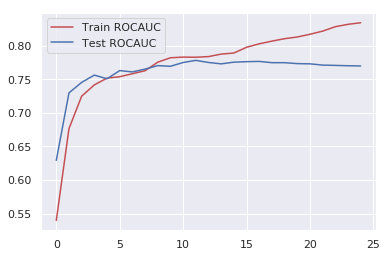

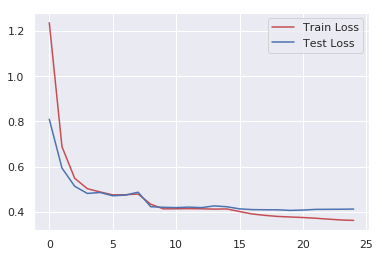

In [49]:
sns.set()
plt.plot(history.history['auroc'], 'r')
plt.plot(history.history['val_auroc'], 'b')
plt.legend({'Train ROCAUC': 'r', 'Test ROCAUC':'b'})
plt.show()


plt.plot(history.history['loss'], 'r')
plt.plot(history.history['val_loss'], 'b')
plt.legend({'Train Loss': 'r', 'Test Loss':'b'})
plt.show()

# Conclusion

1. First tried with simple model or baseline model got auc of 0.50 which is bad.
2. Tried regularizer like dropout and BatchNormalization got auc more then 0.50 i.e around 0.70.
3. Tried various featurization technique auc was approx same in every featurization.
4. Using Bi-directional and LSTM achieved more auc then 0.70 i.e around 0.76
5. Tried adding more features like time based, word count, text length, sentiment polarity but auc was aprrox same.
6. Tried different NLP technique like Topic modeling got auc of 0.7751
7. Best model was featurization and extra feature of topic modeling.

In [2]:
from prettytable import PrettyTable

x = PrettyTable()
x.field_names = ['Model with feature','AUC']
x.add_row(['Mode with countvectorizer','0.76'])
x.add_row(['Model essay feature using LSTM','0.76'])
x.add_row(['Model essay feature using Bi-directional lstm/Gru ','0.77'])
x.add_row(['Model with convolutional layer','0.77'])
x.add_row(['Model essay feature with topic modeling as essay feature ','0.7751'])

print(x)

+-----------------------------------------------------------+--------+
|                     Model with feature                    |  AUC   |
+-----------------------------------------------------------+--------+
|                 Mode with countvectorizer                 |  0.76  |
|               Model essay feature using LSTM              |  0.76  |
|     Model essay feature using Bi-directional lstm/Gru     |  0.77  |
|               Model with convolutional layer              |  0.77  |
| Model essay feature with topic modeling as essay feature  | 0.7751 |
+-----------------------------------------------------------+--------+


1. Importing package and loading the data<br>
2. Performing EDA to get insgihts of data<br>
3. Pre-processing the data and cleaning the data<br>
4. Using featurization to convert text data into numerical form<br>
5. Defining embedding matrix and input-output for all feature<br>
6. Concatinating last layer of every feature to a single layer<br>
7. Compile and training deep learning model i.e Keras<br>
8. Tried with different hyperparameter tuning like dropout,BatchNormalization<br>
9. Final step Conclusion<br>